In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

# 0. Functions

In [2]:
def ll_calc(y_sim, y_mes, std):
    ll = np.prod(stats.norm.pdf(y_sim, loc=y_mes, scale=std))
    return ll

In [3]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'2.8% Median: {med1} \n Stats: {stat1} \n')
    print(f'5.6% Median: {med2} \n Stats: {stat2} \n')
    print(f'8.4% Median: {med3} \n Stats: {stat3} \n')
    print(f'11.2% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    return meds, maxs

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    print(f'AGR Median: {medagr} \n Stats: {statagr} \n')
    print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    return meds, maxs

In [4]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Log Likelihood', fontsize=14, labelpad=15)
        ax.set_xlim(0, 10000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [2]:
pklfile = '../../prep-pkls/nucmoles_mlecompare_sep2019/bigger-mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)

In [3]:
XY.shape

(127770, 20)

## (a) Replace nuclide concentrations with ratios

- cs137/cs133
- cs134/cs137
- cs135/cs137
- ba136/ba138
- sm150/sm149
- sm152/sm149
- eu154/eu153
- pu240/pu239
- pu241/pu239
- pu242/pu239

In [90]:
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
ratios = XY.loc[:, lbls].copy()

In [91]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)

## (b) Get test sample for LL calcs

In [92]:
ratios.sample(15)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
23965,phwr,841.739933,0.711,1291.26,candu37,0.877072,0.000802,0.330038,0.001106,4.821656,2.241128,0.013228,0.022386,0.000494,5.646212e-06
113045,agr,4779.858373,3.830,7345.13,agr,0.687500,0.000370,0.663238,0.005079,33.087598,16.816999,0.028947,0.206789,0.035905,6.035147e-03
1362,pwr,707.815164,3.080,213.67,ce14x14,0.882371,0.000066,0.329230,0.000876,0.221286,0.327035,0.001819,0.003079,0.000030,5.672174e-08
35916,agr,1698.270722,4.020,2103.39,agr,0.829918,0.001619,0.548718,0.002252,8.410122,3.694590,0.024164,0.067283,0.006050,1.741800e-04
74329,phwr,2259.911770,0.711,4559.18,candu37,0.802469,0.001091,0.345249,0.001955,20.045956,11.047794,0.031544,0.083795,0.005160,2.788439e-04
104633,pwr,5298.865497,2.990,7405.17,ce14x14,0.673794,0.000298,0.356381,0.004283,21.386301,10.761644,0.029355,0.143886,0.026281,3.739531e-03
11056,agr,58.975764,4.110,488.64,agr,0.920108,0.001111,0.497277,0.001092,1.420376,0.711078,0.008444,0.014837,0.000374,1.863173e-06
47156,phwr,1048.356648,0.711,2725.95,candu37,0.865755,0.001737,0.326622,0.001453,11.304348,5.796196,0.026494,0.049366,0.002295,6.014925e-05
96300,phwr,2833.666406,0.711,5482.97,candu37,0.774213,0.000825,0.354027,0.002203,24.569843,13.820537,0.032391,0.101635,0.006358,4.555914e-04
37186,agr,1164.634502,4.020,2257.12,agr,0.858571,0.002735,0.530822,0.002337,9.069565,4.020000,0.028751,0.071875,0.007421,2.141155e-04


In [93]:
# Choosing PHWR sample intentionally
sim_idx = 45512
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
45512,phwr,1957.77092,0.711,2191.35,candu37


## (c) LL calcs for uncertainty = 2.8%, 5.6%, 8.4%, 11.2%

In [94]:
fullXY = ratios.loc[ratios['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [95]:
#uncs = [0.028, 0.056, 0.084, 0.112]
uncs = [0.112, 0.14, 0.168, 0.196]
for unc in uncs:
    ll_name = 'Likelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
#    unc_name = 'LLUncertainty_' + str(unc)
#    trainXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

## Viz of train set

In [28]:
med = ["#d8b365", "#5ab4ac", "#af8dc3"]
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    if 'total' in dfX.columns:
        dfX.drop('total', axis=1, inplace=True)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(XY)
y = ratios.ReactorType
lda = LinearDiscriminantAnalysis(n_components=2)
fit = lda.fit(X, y).transform(X)
fit_df = pd.DataFrame(fit, columns=['x1', 'x2'])
df = pd.concat([fit_df, y], axis=1)

<Figure size 648x576 with 0 Axes>

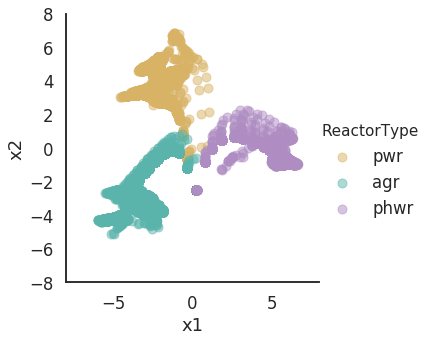

In [63]:
plt.clf()
sns.set_style('white')
sns.set_context('talk')
#sns.set(rc={'figure.figsize':(9,8)})
sns.lmplot(x='x1', y='x2', hue="ReactorType", palette=med, data=df, fit_reg=False, scatter_kws={'alpha':0.5})
#g = sns.lmplot(x='x1', y='x2', hue="ReactorType", palette=med, data=df, legend=False, fit_reg=False, scatter_kws={'alpha':0.5})
#plt.legend(loc='upper right', markerscale=2)
#g._legend.set_title("Reactor Type")
#for lh in g._legend.legendHandles: 
#    lh.set_alpha(1)
#    lh.set_sizes([50]) 
plt.ylim(-8, 8)
plt.xlim(-8, 8)
plt.show()

In [65]:
saveme = g.ax.get_figure()
saveme.savefig('lda-trainset.png', transparent=True)
#saveme.savefig('lda-trainset-grey.png')

## (d) Half trainset + full trainset

In [67]:
trainXY = fullXY.sample(frac=0.5)

# 2. Likelihood for 3 reactors with Uncertainty = 11%

In [15]:
ll = 'Likelihood_0.112'
zname = [ll, ll, ll, ll]
rxtrs = ['PWR', 'AGR', 'PHWR', 'All']

## (a) Half trainset

In [18]:
trainXY_pwr = trainXY.loc[trainXY['ReactorType'] == 'pwr'].copy()
trainXY_agr = trainXY.loc[trainXY['ReactorType'] == 'agr'].copy()
trainXY_phwr = trainXY.loc[trainXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll)
plotXY1 = trainXY_pwr#.loc[trainXY_pwr[ll] > meds[0]]
plotXY2 = trainXY_agr#.loc[trainXY_agr[ll] > meds[1]]
plotXY3 = trainXY_phwr#.loc[trainXY_phwr[ll] > meds[2]]
plotXY4 = trainXY#.loc[trainXY[ll] > meds[3]]

PWR Median: 1.7826763514818755e-49 
 Stats: DescribeResult(nobs=21236, minmax=(0.0, 5.088777161617084e-10), mean=1.1501212587057937e-13, variance=3.1260253235066264e-23, skewness=68.84432168711355, kurtosis=5267.135113147968) 

AGR Median: 8.00942976136628e-60 
 Stats: DescribeResult(nobs=21302, minmax=(0.0, 4.205767477742885e-09), mean=7.769036678654113e-13, variance=2.0304229863217764e-21, skewness=81.23917774039438, kurtosis=7126.265752505266) 

PHWR Median: 2.7243263988777584e-45 
 Stats: DescribeResult(nobs=21340, minmax=(0.0, 1.2829381376884568e+21), mean=5.747850131786457e+18, variance=4.214040641237578e+39, skewness=14.596251274946107, kurtosis=234.27922762935498) 

All Median: 1.1869274675824473e-52 
 Stats: DescribeResult(nobs=63878, minmax=(0.0, 1.2829381376884568e+21), mean=1.92020917706132e+18, variance=1.4151088548536742e+39, skewness=25.360835856608166, kurtosis=710.1599890643981) 



/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


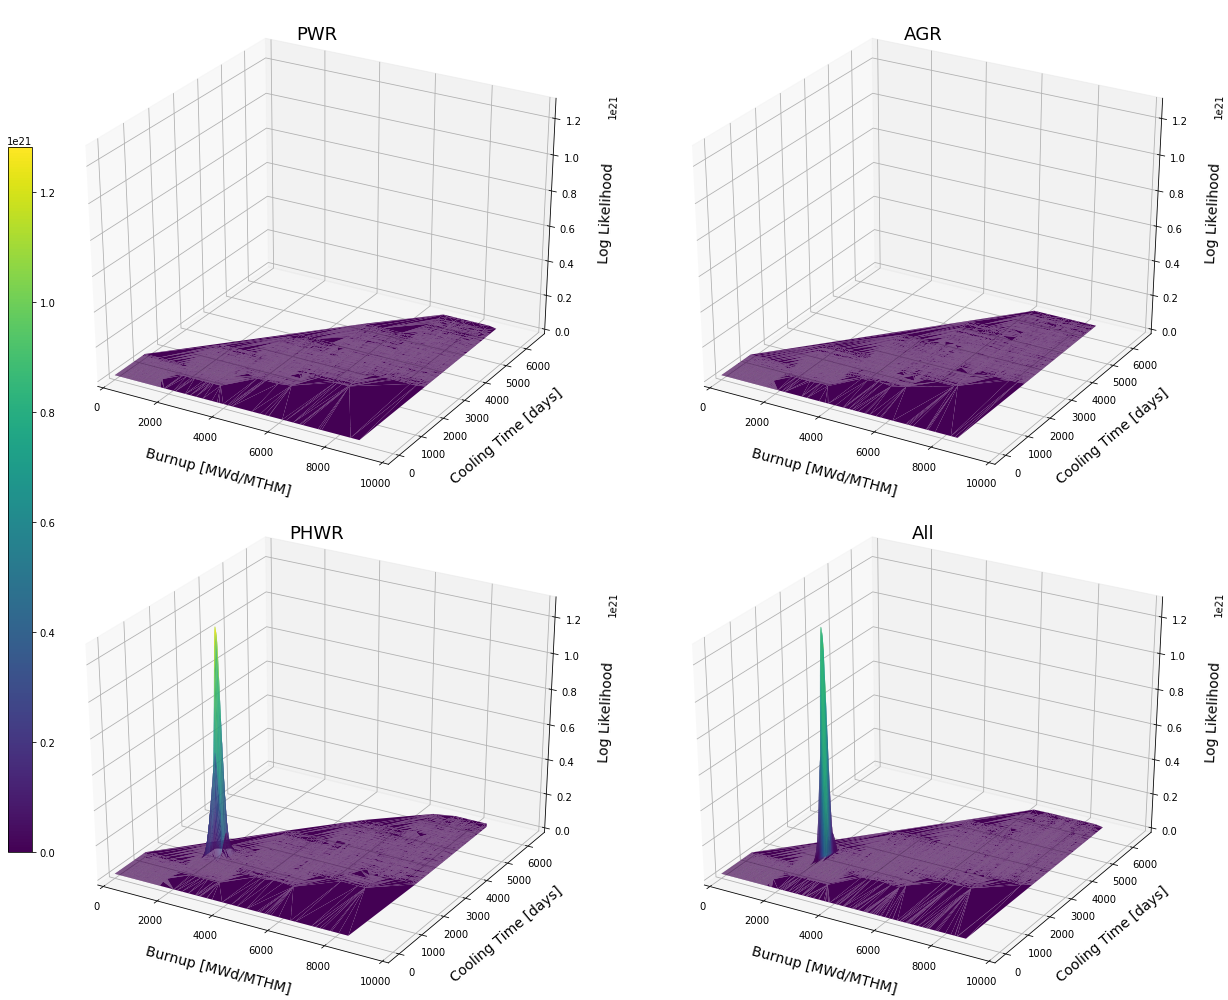

In [19]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=0.0, vmax=max(maxs))

## (b) Full trainset

In [69]:
fullXY_pwr = fullXY.loc[fullXY['ReactorType'] == 'pwr'].copy()
fullXY_agr = fullXY.loc[fullXY['ReactorType'] == 'agr'].copy()
fullXY_phwr = fullXY.loc[fullXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(fullXY_pwr, fullXY_agr, fullXY_phwr, fullXY, ll)
plotXY1 = fullXY_pwr.loc[fullXY_pwr[ll] > meds[0]]
plotXY2 = fullXY_agr.loc[fullXY_agr[ll] > meds[1]]
plotXY3 = fullXY_phwr.loc[fullXY_phwr[ll] > meds[2]]
plotXY4 = fullXY.loc[fullXY[ll] > meds[3]]

NameError: name 'll' is not defined

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


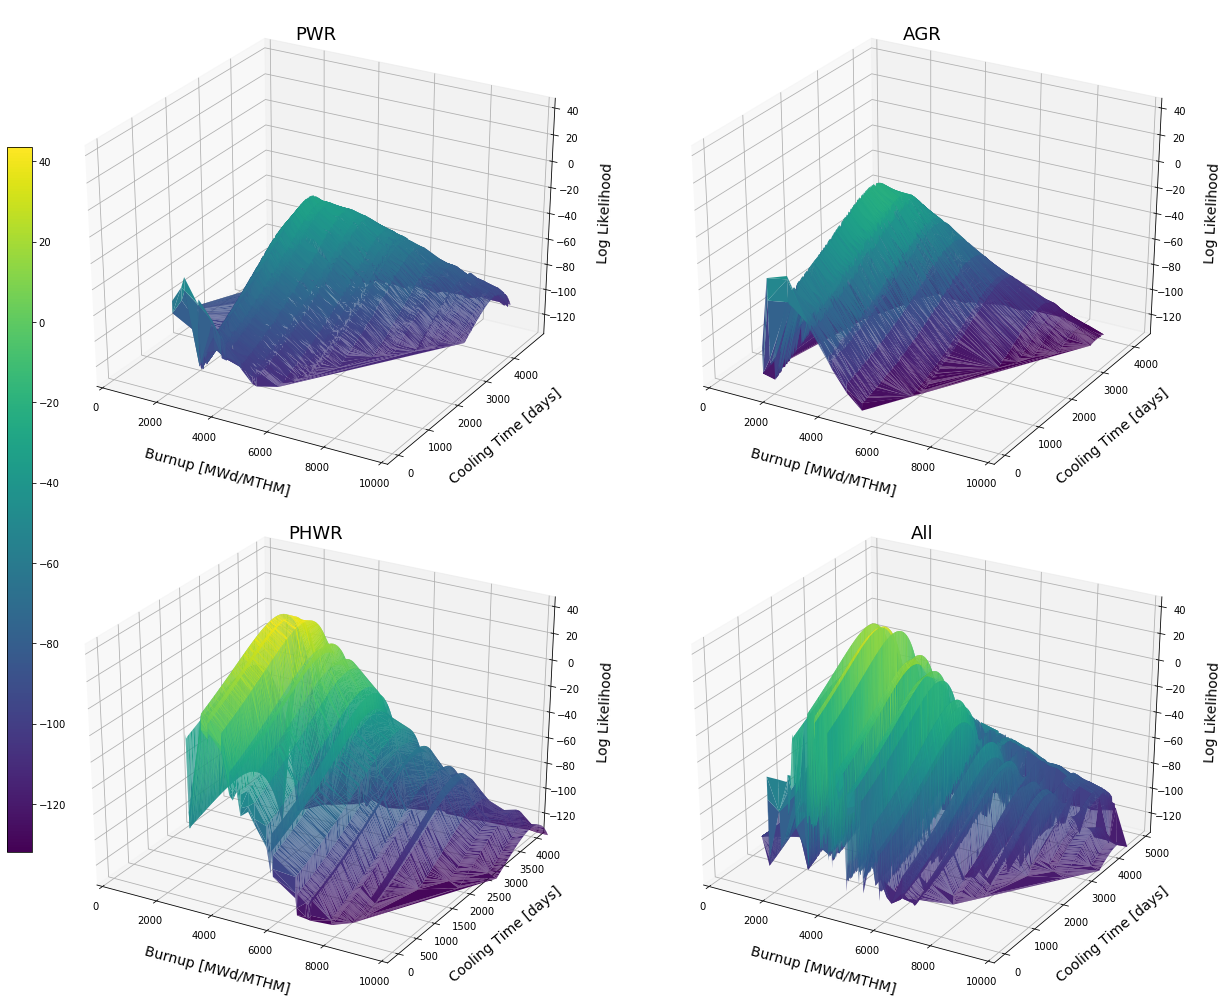

In [17]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs))

# 3. LogLikelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [86]:
ll1 = 'Likelihood_0.028'
ll2 = 'Likelihood_0.056'
ll3 = 'Likelihood_0.084'
ll4 = 'Likelihood_0.112'
zname = [ll1, ll2, ll3, ll4]
uncss = ['2.8% Uncertainty', '5.6% Uncertainty', '8.4% Uncertainty', '11.2% Uncertainty']

In [71]:
meds, maxs = getstats_unc(fullXY, ll1, ll2, ll3, ll4)
#plots, pltlabels, zname, vmin, vmax

2.8% Median: 0.0 
 Stats: DescribeResult(nobs=127755, minmax=(0.0, 1.2996972641392138e+27), mean=2.168676170274452e+23, variance=1.687311460065635e+50, skewness=75.27437395460218, kurtosis=6276.106707178494) 

5.6% Median: 5.141186262270007e-255 
 Stats: DescribeResult(nobs=127755, minmax=(0.0, 1.2721958593810387e+24), mean=5.926699322979878e+20, variance=4.684163875750553e+44, skewness=44.96387712978427, kurtosis=2177.3623699936516) 

8.4% Median: 6.7812034009726216e-105 
 Stats: DescribeResult(nobs=127755, minmax=(0.0, 2.2144728260395076e+22), mean=1.9788958970537468e+19, variance=2.5814702205357993e+41, skewness=33.33619832337929, kurtosis=1220.6504914572236) 

11.2% Median: 9.159022463280997e-53 
 Stats: DescribeResult(nobs=127755, minmax=(0.0, 1.282946734618355e+21), mean=1.8336210231807956e+18, variance=1.3213750732539516e+39, skewness=25.589859913162687, kurtosis=729.0127258773609) 



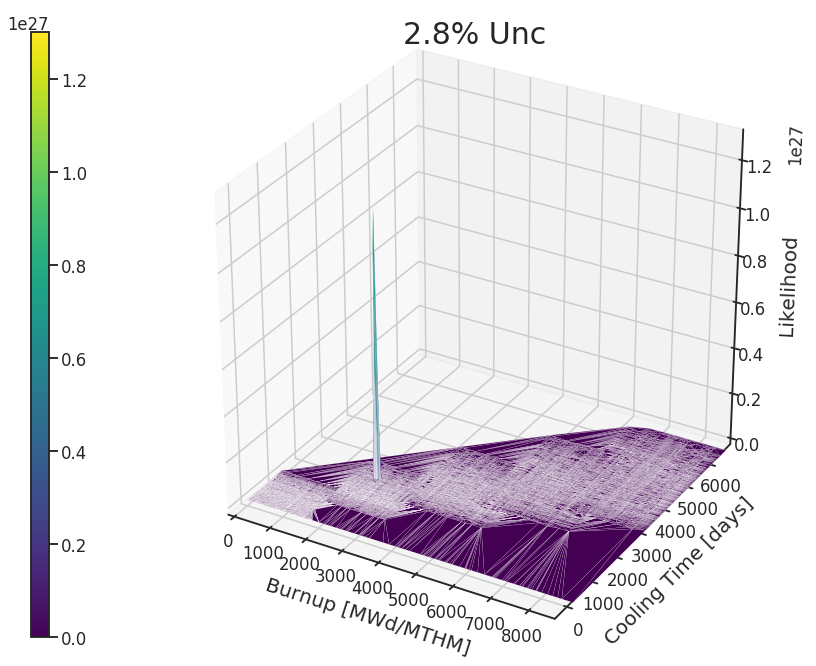

In [84]:
vmin=0
vmax=maxs[0]
plotXY = trainXY#.loc[trainXY[ll1] > 0]

fig = plt.figure(figsize=(12, 12))
cmap = sns.cubehelix_palette(6, as_cmap=True)
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
ax = fig.add_subplot(111, projection='3d')
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = plotXY[ll1]
surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
ax.set_title(uncss[0], fontsize=30, pad=15)
ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
ax.set_zlabel('Likelihood', fontsize=20, labelpad=15)
ax.set_xlim(0, 8500)
ax.set_zlim(vmin, vmax)
cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
fig.colorbar(surf, cax=cbar_ax)
#ax.view_init(azim=30)
plt.show()

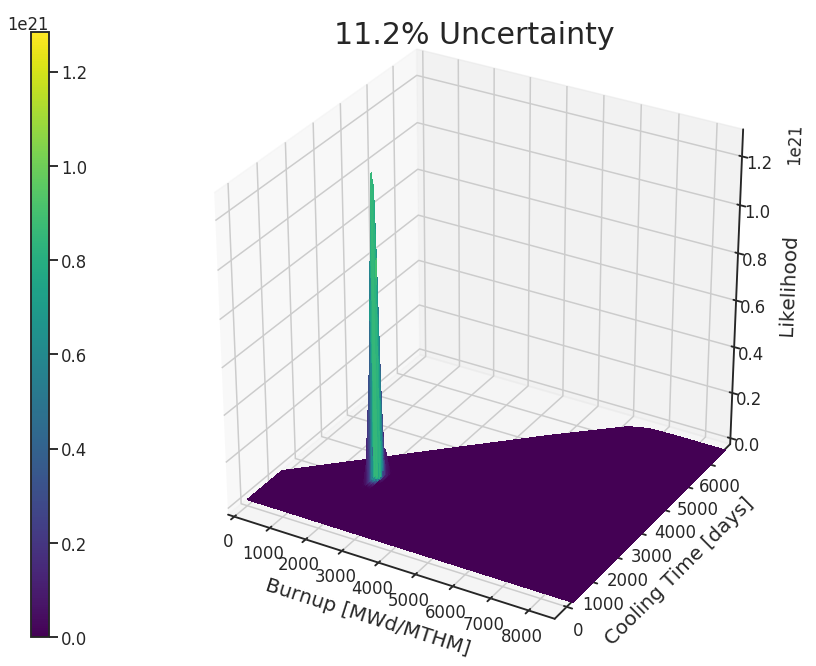

In [99]:
vmin=0
vmax=maxs[3]

fig = plt.figure(figsize=(12, 12))
cmap = sns.cubehelix_palette(6, as_cmap=True)
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
ax = fig.add_subplot(111, projection='3d')
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = plotXY[ll4]
surf = ax.plot_trisurf(triang, z, edgecolor='none', linewidth=0, antialiased=False, norm=norm, cmap=matplotlib.cm.viridis)#, shade=True)
ax.set_title(uncss[3], fontsize=30, pad=15)
ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
ax.set_zlabel('Likelihood', fontsize=20, labelpad=15)
ax.set_xlim(0, 8500)
ax.set_zlim(vmin, vmax)
cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
fig.colorbar(surf, cax=cbar_ax)
#ax.view_init(azim=30)
plt.show()

## (a) Half trainset

In [22]:
meds, maxs = getstats_unc(trainXY, ll1, ll2, ll3, ll4)

2.8% Median: 0.0 
 Stats: DescribeResult(nobs=63878, minmax=(0.0, 1.1569194637011077e+27), mean=2.2967056897172405e+23, variance=1.656026064530084e+50, skewness=69.13929542540791, kurtosis=5225.097240041375) 

5.6% Median: 1.2464329301926e-254 
 Stats: DescribeResult(nobs=63878, minmax=(0.0, 1.2509723984301672e+24), mean=6.544408286759901e+20, variance=5.177812667249764e+44, skewness=42.01747600056536, kurtosis=1899.5068103029407) 

8.4% Median: 8.993657884524288e-105 
 Stats: DescribeResult(nobs=63878, minmax=(0.0, 2.210693698606045e+22), mean=2.1058293938005623e+19, variance=2.8507430917220405e+41, skewness=32.13767719044482, kurtosis=1119.710881227674) 

11.2% Median: 1.1869274675824473e-52 
 Stats: DescribeResult(nobs=63878, minmax=(0.0, 1.2829381376884568e+21), mean=1.92020917706132e+18, variance=1.4151088548536742e+39, skewness=25.360835856608166, kurtosis=710.1599890643981) 



In [23]:
cutoff = 0

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


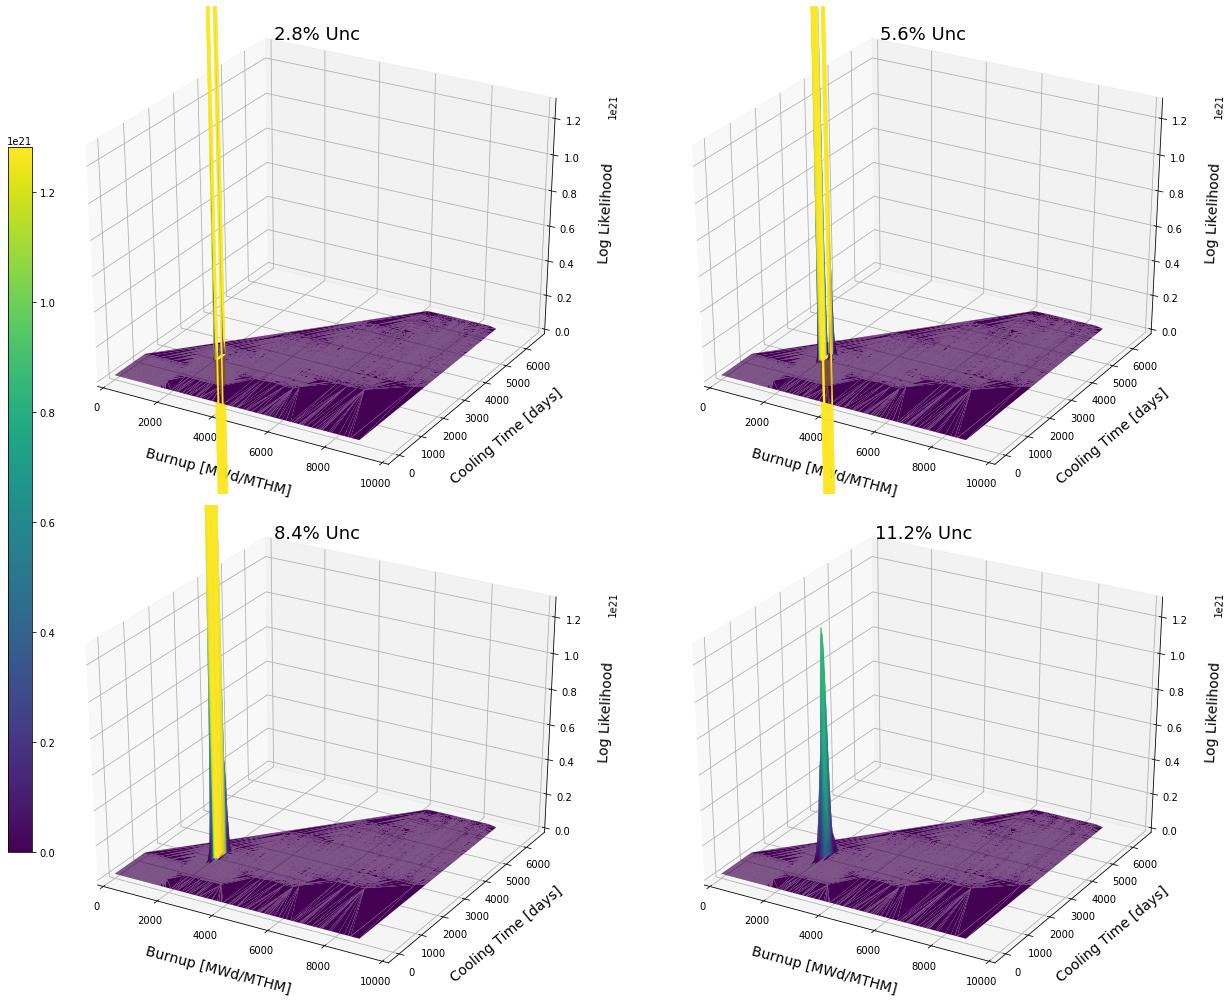

In [26]:
plotXY1 = trainXY.loc[trainXY[ll1] > cutoff]
plotXY2 = trainXY.loc[trainXY[ll2] > cutoff]
plotXY3 = trainXY.loc[trainXY[ll3] > cutoff]
plotXY4 = trainXY.loc[trainXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=min(maxs))

## (b) Full trainset

In [29]:
meds, maxs = getstats_unc(fullXY, ll1, ll2, ll3, ll4)

2.8% Median: -2417.885353193109 
 Stats: DescribeResult(nobs=73146, minmax=(-786506914.9065645, 57.45131447752493), mean=-5219401.396430869, variance=2117677796567962.5, skewness=-9.601146331306941, kurtosis=95.59589432596316) 

5.6% Median: -575.698298546115 
 Stats: DescribeResult(nobs=73146, minmax=(-196626670.64984477, 50.521789914905646), mean=-1304817.0777492167, variance=132354807603821.81, skewness=-9.6011468150856, kurtosis=95.5959044497773) 

8.4% Median: -237.148438731981 
 Stats: DescribeResult(nobs=73146, minmax=(-87389591.15112701, 46.46763371934429), mean=-579896.8268163238, variance=26144141524513.652, skewness=-9.601147621369766, kurtosis=95.59592132262263) 

11.2% Median: -120.16294101927173 
 Stats: DescribeResult(nobs=73146, minmax=(-49156614.78426867, 43.5992616241531), mean=-326176.19668265776, variance=8272161804863.473, skewness=-9.601148750139041, kurtosis=95.595944944232) 



/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


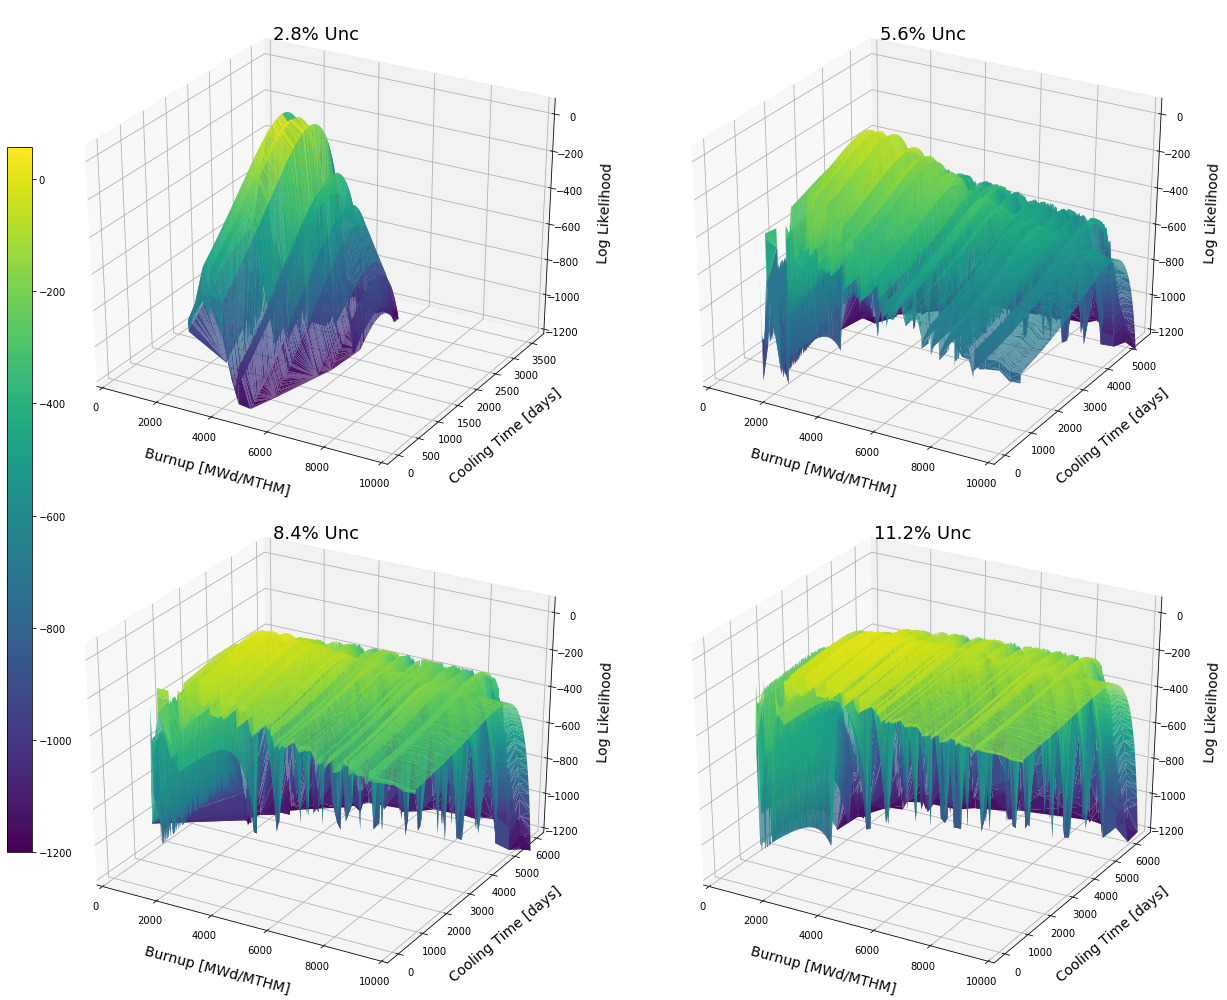

In [30]:
plotXY1 = fullXY.loc[fullXY[ll1] > cutoff]
plotXY2 = fullXY.loc[fullXY[ll2] > cutoff]
plotXY3 = fullXY.loc[fullXY[ll3] > cutoff]
plotXY4 = fullXY.loc[fullXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))